# Compress momentum dependence at the lowest frequency

In [45]:
using Revise
using PyPlot
using LinearAlgebra
using SparseIR
using MultiScales

newaxis = [CartesianIndex()]

1-element Vector{CartesianIndex{0}}:
 CartesianIndex()

In [46]:
BLAS.set_num_threads(16)

In [47]:
println(Threads.nthreads())

1


In [48]:
using ITensors

println(ITensors.blas_get_num_threads())

16


In [49]:
beta = 1.0

ek(k) = 2*cos(k)

ek (generic function with 1 method)

In [50]:
N = 10
half_N = N ÷ 2
nk = 2^N
nk

1024

In [51]:
wmax = 10.0
basis = FiniteTempBasis(Fermionic(), beta, wmax, 1e-10)
smpl = MatsubaraSampling(basis)

MatsubaraSampling64F
Sampling points: FermionicFreq[-43π/β, -15π/β, -9π/β, -7π/β, -5π/β, -3π/β, -1π/β, π/β, 3π/β, 5π/β, 7π/β, 9π/β, 15π/β, 43π/β]


In [52]:
kmesh = LinRange(0, 2π, nk)
v = smpl.sampling_points
iv = SparseIR.valueim.(v, beta)
nw = length(v)

giv0 = 1 ./ (iv[:,newaxis] .- ek.(kmesh)[newaxis,:])
size(giv0)

(14, 1024)

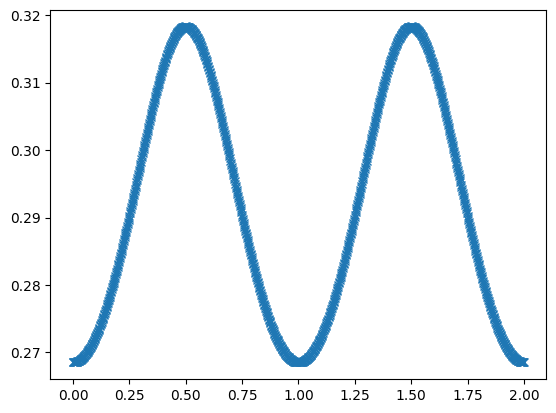

In [53]:
figure()
plot(kmesh/π, vec(maximum(abs, giv0, dims=1)), marker=:x)
display(gcf())

In [54]:
sitew = Index(nw, "w")
sitesk = [Index(2, "Qubit,k=$k") for k in 1:N]
tensor = ITensor(reshape(giv0, nw, repeat([2,], N)...), [sitew, reverse(sitesk)...])
;

In [55]:
u, s, vt = svd(tensor, sitesk[N÷2+1:end])
;

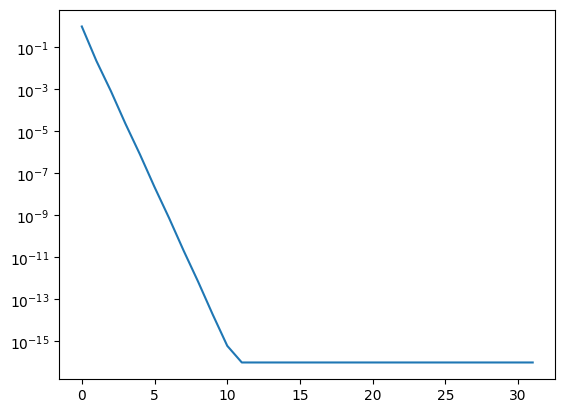

In [56]:
figure()
s_ = Vector(diag(s))
semilogy(s_/s_[1])
display(gcf())

In [57]:
sites = [sitew, sitesk...]

11-element Vector{Index{Int64}}:
 (dim=14|id=18|"w")
 (dim=2|id=499|"Qubit,k=1")
 (dim=2|id=34|"Qubit,k=2")
 (dim=2|id=816|"Qubit,k=3")
 (dim=2|id=945|"Qubit,k=4")
 (dim=2|id=831|"Qubit,k=5")
 (dim=2|id=442|"Qubit,k=6")
 (dim=2|id=86|"Qubit,k=7")
 (dim=2|id=558|"Qubit,k=8")
 (dim=2|id=933|"Qubit,k=9")
 (dim=2|id=599|"Qubit,k=10")

In [58]:
cutoff = 1E-10
maxdim = 20000
M = MPS(tensor, sites; cutoff=cutoff, maxdim=maxdim)

MPS
[1] ((dim=14|id=18|"w"), (dim=6|id=836|"Link,n=1"))
[2] ((dim=6|id=836|"Link,n=1"), (dim=2|id=499|"Qubit,k=1"), (dim=7|id=453|"Link,n=2"))
[3] ((dim=7|id=453|"Link,n=2"), (dim=2|id=34|"Qubit,k=2"), (dim=7|id=575|"Link,n=3"))
[4] ((dim=7|id=575|"Link,n=3"), (dim=2|id=816|"Qubit,k=3"), (dim=6|id=722|"Link,n=4"))
[5] ((dim=6|id=722|"Link,n=4"), (dim=2|id=945|"Qubit,k=4"), (dim=5|id=89|"Link,n=5"))
[6] ((dim=5|id=89|"Link,n=5"), (dim=2|id=831|"Qubit,k=5"), (dim=4|id=275|"Link,n=6"))
[7] ((dim=4|id=275|"Link,n=6"), (dim=2|id=442|"Qubit,k=6"), (dim=3|id=655|"Link,n=7"))
[8] ((dim=3|id=655|"Link,n=7"), (dim=2|id=86|"Qubit,k=7"), (dim=3|id=856|"Link,n=8"))
[9] ((dim=3|id=856|"Link,n=8"), (dim=2|id=558|"Qubit,k=8"), (dim=3|id=554|"Link,n=9"))
[10] ((dim=3|id=554|"Link,n=9"), (dim=2|id=933|"Qubit,k=9"), (dim=2|id=891|"Link,n=10"))
[11] ((dim=2|id=891|"Link,n=10"), (dim=2|id=599|"Qubit,k=10"))


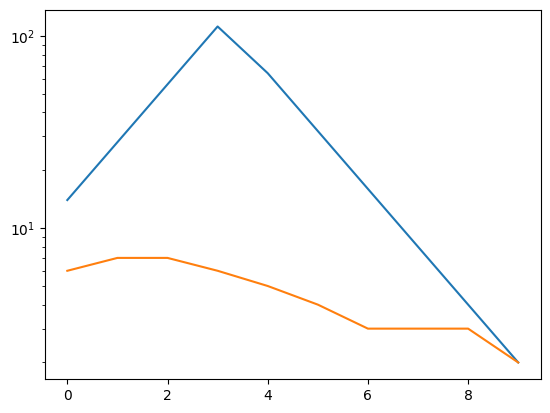

In [59]:
figure()
semilogy(MultiScales.maxlinkdims(sites))
semilogy(MultiScales.linkdims(M))
display(gcf())
savefig("1d_freqmomdep_beta$(Int(beta))_N$N.pdf")

In [60]:
tensor_reconst = Array(reduce(*, M), sites...)
;

In [61]:
bonddims = collect(size(m)[1] for m in M)
plot(bonddims)

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x14d770c29790>